# Diffusion models

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import sys

from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

project_root = Path().absolute().parent
sys.path.append(str(project_root))
project_root

PosixPath('/home/aorellan/DiffusionArcade')

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
from src.diffusion.model import login_huggingface

login_huggingface()

#### Utils to show images and make grids

In [15]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.asarray(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

### Dataset

In [16]:
dataset = load_dataset(
    "imagefolder",
    data_dir="../screens/",
    split="train"
)

Resolving data files:   0%|          | 0/1592 [00:00<?, ?it/s]

In [17]:
dataset

Dataset({
    features: ['image'],
    num_rows: 1592
})

In [9]:
split_datasets = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets["train"]
val_dataset   = split_datasets["test"]

In [92]:
image_size = 128
batch_size = 64

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),   # Resize to square
    transforms.Grayscale(num_output_channels=1),   # → single‐channel “L” image
    transforms.ToTensor(),                         # → tensor in [0,1], shape = [1,H,W]
    transforms.Normalize([0.5], [0.5]),            # → tensor in [−1,1]
])


def transform(examples):
    imgs = [preprocess(img) for img in examples["image"]]
    return {"image": imgs}

train_dataset.set_transform(transform)
val_dataset.set_transform(transform)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

X shape: torch.Size([8, 1, 128, 128])
Batch of images in training dataset:


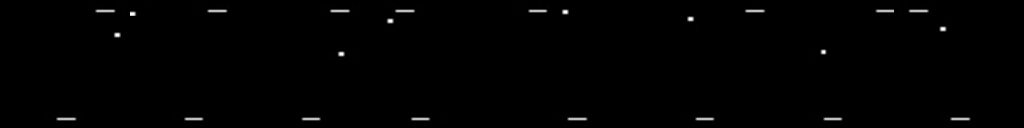

In [93]:
train_batch_images = next(iter(train_dataloader))["image"].to(device)[:8]
print("X shape:", train_batch_images.shape)

print('Batch of images in training dataset:')
show_images(train_batch_images).resize((8 * 128, 128), resample=Image.NEAREST)

X shape: torch.Size([8, 1, 128, 128])
Batch of images in validation dataset:


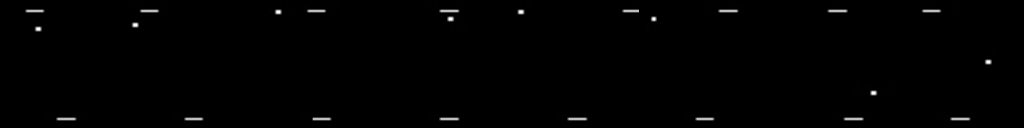

In [94]:
val_batch_images = next(iter(val_dataloader))["image"].to(device)[:8]
print("X shape:", val_batch_images.shape)

print('Batch of images in validation dataset:')
show_images(val_batch_images).resize((8 * 128, 128), resample=Image.NEAREST)

## Diffusion model

#### Forward diffusion process

In [95]:
from diffusers import DDIMScheduler # We can also use DDPM scheduler, but this is slower

timesteps = 1000

schedulers = {
    "cosine": DDIMScheduler(
        num_train_timesteps=timesteps,
        beta_schedule="squaredcos_cap_v2"
    ),
    "linear": DDIMScheduler(
        num_train_timesteps=timesteps,
        beta_schedule="linear"
    ),
}

The forward diffusion process progressively adds noise to the original image $\mathbf{x}_0$ as timestep $t$ increases.

The process is defined by the re-parameterization formula:

$$
q(\mathbf{x}_t \mid \mathbf{x}_0)
    = \mathcal{N}\!\bigl(
        \mathbf{x}_t;\,
        \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0,\,
        (1 - \bar{\alpha}_t)\,\mathbf{I}
      \bigr)
$$

where:

* $\mathbf{x}_t$ — noisy image at timestep $t$  
* $\sqrt{\bar{\alpha}_t}$ — scales down the original image  
* $1-\bar{\alpha}_t$ — variance of the added Gaussian noise

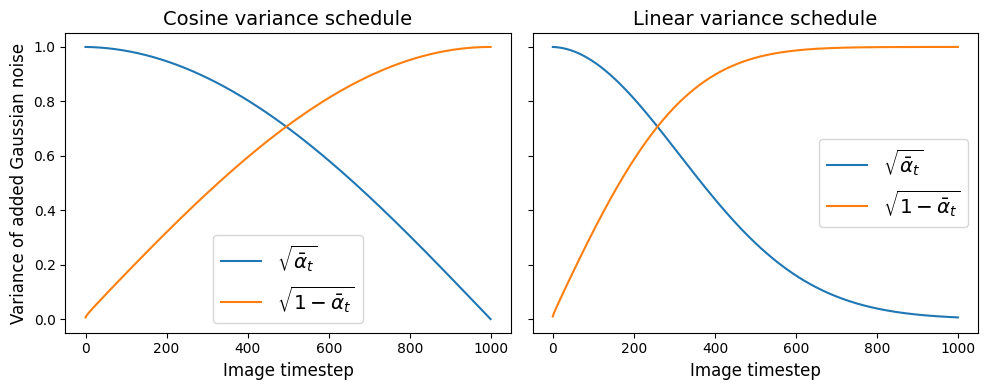

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, (name, sched) in zip(axes, schedulers.items()):
    alphas_cumprod = sched.alphas_cumprod.cpu()
    
    ax.plot(
        alphas_cumprod ** 0.5,
        label=r"$\sqrt{\bar{\alpha}_t}$"
    )
    ax.plot(
        (1 - alphas_cumprod) ** 0.5,
        label=r"$\sqrt{1 - \bar{\alpha}_t}$"
    )
    ax.set_title(f"{name.capitalize()} variance schedule", fontsize=14)
    ax.set_xlabel("Image timestep", fontsize=12)
    ax.legend(fontsize="x-large")
    
axes[0].set_ylabel("Variance of added Gaussian noise", fontsize=12)

plt.tight_layout()
plt.show()

The more time steps, the more noise is added to the original image $\mathbf{x}_0$

In [97]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')

The following images demonstrate the progressive addition of noise to the original image $\mathbf{x}_0$ across different timesteps. The sequence shows a gradual transition from minimal noise in the initial images to almost complete noise in the final image.

Noisy X shape torch.Size([8, 1, 128, 128])


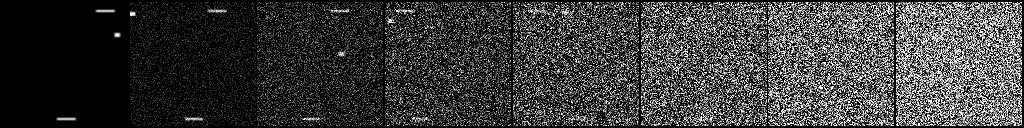

In [98]:
noise = torch.randn_like(train_batch_images) # same shape as xb: [Batch size, Channels, Height, Width]

noisy_train_batch_images = schedulers["cosine"].add_noise(train_batch_images, noise, timesteps)
print("Noisy X shape", train_batch_images.shape)
show_images(noisy_train_batch_images).resize((8 * 128, 128), resample=Image.NEAREST)

#### Training

In [18]:
from src.diffusion.model import DiffusionModel, load_config

In [23]:
config = load_config("../config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size=config['training']['image_size']
in_channels=config['training']['in_channels']
out_channels=config['training']['out_channels']
timesteps = config['training']['timesteps']
beta_schedule=config['training']['beta_schedule']

model = DiffusionModel(
    image_size=image_size,
    in_channels=in_channels,
    out_channels=out_channels,
    device=device,
    timesteps=timesteps,
    beta_schedule=beta_schedule,
)

In [101]:
epochs = config["training"]["epochs"]
lr = config["training"]["learning_rate"]
wandb_cfg = {
    "project": config["wandb"]["project"],
    "entity": config["wandb"]["entity"],
    "name": config["wandb"]["run_name"],
    "config": config
}

train_losses, val_losses = model.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=epochs,
    lr=lr,
    wandb_config=wandb_cfg,
)

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,██▇▅▅▃▃▃▃▃▃▂▃▂▂▁▁▁▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁
epoch,30
epoch/train_loss,0.00161
epoch/val_loss,0.00187
train/loss,0.00114


Epoch 1/30:   0%|                                                                                                                             | 0/20 [00:00<?, ?it/s]/home/aorellan/miniconda3/envs/diffusion_arcade/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.0292]


Epoch [1/30] Train Loss: 0.1618 Val Loss: 0.0320


Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.0191]


Epoch [2/30] Train Loss: 0.0244 Val Loss: 0.0205


Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.0158]


Epoch [3/30] Train Loss: 0.0161 Val Loss: 0.0131


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.0105]


Epoch [4/30] Train Loss: 0.0121 Val Loss: 0.0104


Epoch 5/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00804]


Epoch [5/30] Train Loss: 0.0101 Val Loss: 0.0103


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.011]


Epoch [6/30] Train Loss: 0.0084 Val Loss: 0.0066


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.0057]


Epoch [7/30] Train Loss: 0.0065 Val Loss: 0.0058


Epoch 8/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00627]


Epoch [8/30] Train Loss: 0.0064 Val Loss: 0.0070


Epoch 9/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00483]


Epoch [9/30] Train Loss: 0.0056 Val Loss: 0.0043


Epoch 10/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00374]


Epoch [10/30] Train Loss: 0.0041 Val Loss: 0.0035


Epoch 11/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00377]


Epoch [11/30] Train Loss: 0.0034 Val Loss: 0.0030


Epoch 12/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00326]


Epoch [12/30] Train Loss: 0.0037 Val Loss: 0.0035


Epoch 13/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00261]


Epoch [13/30] Train Loss: 0.0033 Val Loss: 0.0034


Epoch 14/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.00234]


Epoch [14/30] Train Loss: 0.0031 Val Loss: 0.0032


Epoch 15/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00211]


Epoch [15/30] Train Loss: 0.0028 Val Loss: 0.0027


Epoch 16/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00188]


Epoch [16/30] Train Loss: 0.0024 Val Loss: 0.0025


Epoch 17/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00206]


Epoch [17/30] Train Loss: 0.0022 Val Loss: 0.0021


Epoch 18/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00184]


Epoch [18/30] Train Loss: 0.0020 Val Loss: 0.0022


Epoch 19/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00207]


Epoch [19/30] Train Loss: 0.0021 Val Loss: 0.0023


Epoch 20/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00286]


Epoch [20/30] Train Loss: 0.0026 Val Loss: 0.0026


Epoch 21/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00205]


Epoch [21/30] Train Loss: 0.0025 Val Loss: 0.0028


Epoch 22/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00197]


Epoch [22/30] Train Loss: 0.0020 Val Loss: 0.0017


Epoch 23/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00166]


Epoch [23/30] Train Loss: 0.0018 Val Loss: 0.0019


Epoch 24/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00177]


Epoch [24/30] Train Loss: 0.0016 Val Loss: 0.0021


Epoch 25/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00162]


Epoch [25/30] Train Loss: 0.0016 Val Loss: 0.0018


Epoch 26/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00178]


Epoch [26/30] Train Loss: 0.0017 Val Loss: 0.0014


Epoch 27/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00117]


Epoch [27/30] Train Loss: 0.0017 Val Loss: 0.0017


Epoch 28/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00235]


Epoch [28/30] Train Loss: 0.0017 Val Loss: 0.0014


Epoch 29/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00128]


Epoch [29/30] Train Loss: 0.0016 Val Loss: 0.0015


Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.00147]


Epoch [30/30] Train Loss: 0.0017 Val Loss: 0.0020


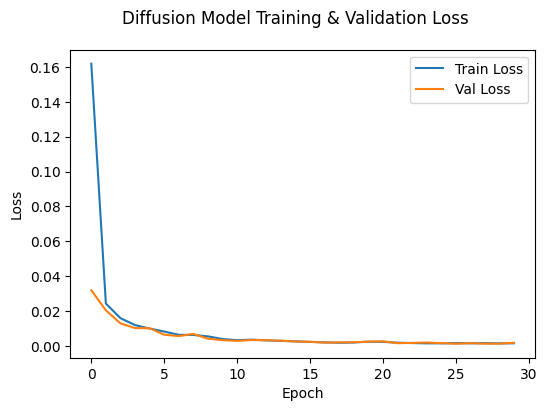

In [102]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Diffusion Model Training & Validation Loss")

ax.plot(train_losses, label="Train Loss")
ax.plot(val_losses, label="Val Loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.show()

#### Generation

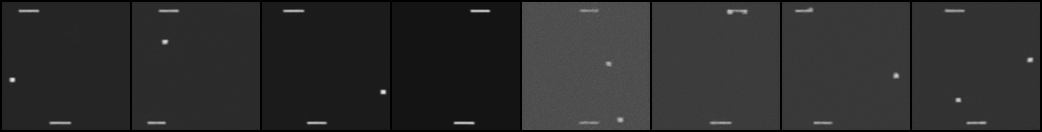

In [105]:
n_images = 8
n_channels = 1
num_inference_steps = 1000

sample = model.generate(n_images, n_channels, num_inference_steps)

show_images(sample)

### Latent representations

In [123]:
config = load_config("../config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size=config['training']['image_size']

dataset = load_dataset(
    "imagefolder",
    data_dir="../screens/",
    split="train"
)

Resolving data files:   0%|          | 0/1592 [00:00<?, ?it/s]

#### 1. Testing VAE

In [20]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").eval().to(device)
# Keep frozen
vae.requires_grad_(False)
SCALE = vae.config.scaling_factor

In [21]:
split_datasets = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets["train"]
val_dataset   = split_datasets["test"]

In [24]:
batch_size = 64

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),   # Resize to square
    transforms.ToTensor(),                         # → tensor in [0,1], shape = [1,H,W]
    transforms.Normalize([0.5], [0.5]),            # → tensor in [−1,1]
])


def encode_batch(examples):
    # convert every image to RGB just to be compatible with VAE format
    imgs = [preprocess(img.convert("RGB")) for img in examples["image"]]
    
    # stack into [B, 1, H, W] and move to device
    batch = torch.stack(imgs, dim=0).to(device)
    print('Before compressing images:', batch.shape)
    
    # encode and sample latents under no_grad
    with torch.no_grad():
        latents = vae.encode(batch).latent_dist.sample() * SCALE

    return {"latents": latents.cpu()}

train_dataset.set_transform(encode_batch)
val_dataset.set_transform(encode_batch)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [25]:
for batch in train_dataloader:
    print('Encoded images -> latents shape:', batch['latents'].shape)
    break

Before compressing images: torch.Size([64, 3, 128, 128])
Encoded images -> latents shape: torch.Size([64, 4, 16, 16])


Before compressing images: torch.Size([64, 3, 128, 128])
Encoded images -> latents shape: torch.Size([64, 4, 16, 16])
Decoded images: torch.Size([64, 3, 128, 128])


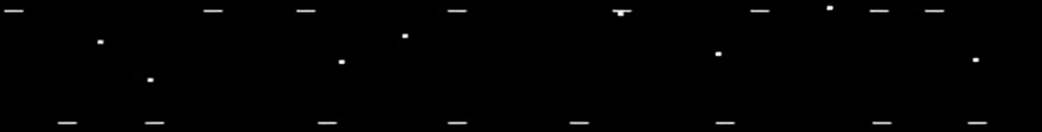

In [26]:
def decode_latents_to_tensor(latents, vae, scale=SCALE, device=device):
    print('Encoded images -> latents shape:', latents.shape)
    
    lat = latents.to(device) / scale
    with torch.no_grad():
        dec = vae.decode(lat).sample       # -> [B, 3, H, W], roughly [-1,1]
        print('Decoded images:', dec.shape)
    return dec.cpu()

batch = next(iter(train_dataloader))
latents = batch["latents"]               # shape [B, C, h, w]

decoded_tensor = decode_latents_to_tensor(latents, vae)[:8]

show_images(decoded_tensor)

### 2. Using VAE in the diffusion model

In [27]:
from src.diffusion.model_with_latents import LatentDiffusionModel, login_huggingface

config = load_config("../config.yaml")

login_huggingface()

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")

In [28]:
model = LatentDiffusionModel(vae=vae)

In [29]:
epochs = config["training"]["epochs"]
lr = config["training"]["learning_rate"]
wandb_cfg = {
    "project": config["wandb"]["project"],
    "entity": config["wandb"]["entity"],
    "name": config['wandb']['run_name'],
    "config": config
}

train_losses, val_losses = model.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=epochs,
    lr=lr,
    wandb_config=wandb_cfg,
)

wandb: Currently logged in as: adriana-orellana-torrico to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/30:   0%|                                                                                                                             | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


/home/aorellan/miniconda3/envs/diffusion_arcade/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/30:   5%|█████▎                                                                                                     | 1/20 [00:00<00:09,  2.09it/s, loss=1.1]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  10%|██████████▌                                                                                              | 2/20 [00:00<00:07,  2.57it/s, loss=0.953]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  15%|███████████████▊                                                                                         | 3/20 [00:01<00:06,  2.81it/s, loss=0.826]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  20%|█████████████████████                                                                                    | 4/20 [00:01<00:05,  2.94it/s, loss=0.714]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  25%|██████████████████████████▎                                                                              | 5/20 [00:01<00:04,  3.02it/s, loss=0.607]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  30%|███████████████████████████████▌                                                                         | 6/20 [00:02<00:04,  3.06it/s, loss=0.542]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  35%|████████████████████████████████████▊                                                                    | 7/20 [00:02<00:04,  3.10it/s, loss=0.517]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  40%|██████████████████████████████████████████                                                               | 8/20 [00:02<00:03,  3.11it/s, loss=0.468]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  45%|███████████████████████████████████████████████▎                                                         | 9/20 [00:03<00:03,  3.11it/s, loss=0.398]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  50%|█████████████████████████████████████████████████████                                                     | 10/20 [00:03<00:03,  3.12it/s, loss=0.4]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  55%|█████████████████████████████████████████████████████████▏                                              | 11/20 [00:03<00:02,  3.13it/s, loss=0.383]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  60%|██████████████████████████████████████████████████████████████▍                                         | 12/20 [00:03<00:02,  3.14it/s, loss=0.352]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  65%|███████████████████████████████████████████████████████████████████▌                                    | 13/20 [00:04<00:02,  3.15it/s, loss=0.325]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  70%|████████████████████████████████████████████████████████████████████████▊                               | 14/20 [00:04<00:01,  3.14it/s, loss=0.304]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  75%|██████████████████████████████████████████████████████████████████████████████                          | 15/20 [00:04<00:01,  3.15it/s, loss=0.269]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  80%|████████████████████████████████████████████████████████████████████████████████████                     | 16/20 [00:05<00:01,  3.16it/s, loss=0.25]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 17/20 [00:05<00:00,  3.16it/s, loss=0.246]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 18/20 [00:05<00:00,  3.17it/s, loss=0.219]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 1/30:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 19/20 [00:06<00:00,  3.17it/s, loss=0.284]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.06it/s, loss=0.217]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [1/30] Train Loss: 0.4689 Val Loss: 0.22876069247722625


Epoch 2/30:   0%|                                                                                                                             | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:   5%|█████▎                                                                                                   | 1/20 [00:00<00:06,  3.15it/s, loss=0.231]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  10%|██████████▌                                                                                              | 2/20 [00:00<00:05,  3.15it/s, loss=0.211]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  15%|███████████████▊                                                                                         | 3/20 [00:00<00:05,  3.16it/s, loss=0.218]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  20%|█████████████████████                                                                                    | 4/20 [00:01<00:05,  3.16it/s, loss=0.197]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  25%|██████████████████████████▎                                                                              | 5/20 [00:01<00:04,  3.16it/s, loss=0.219]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  30%|███████████████████████████████▌                                                                         | 6/20 [00:01<00:04,  3.17it/s, loss=0.162]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  35%|████████████████████████████████████▊                                                                    | 7/20 [00:02<00:04,  3.17it/s, loss=0.234]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  40%|██████████████████████████████████████████                                                               | 8/20 [00:02<00:03,  3.17it/s, loss=0.192]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  45%|███████████████████████████████████████████████▎                                                         | 9/20 [00:02<00:03,  3.17it/s, loss=0.185]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  50%|████████████████████████████████████████████████████                                                    | 10/20 [00:03<00:03,  3.17it/s, loss=0.184]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  55%|█████████████████████████████████████████████████████████▏                                              | 11/20 [00:03<00:02,  3.17it/s, loss=0.186]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  60%|██████████████████████████████████████████████████████████████▍                                         | 12/20 [00:03<00:02,  3.16it/s, loss=0.189]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  65%|███████████████████████████████████████████████████████████████████▌                                    | 13/20 [00:04<00:02,  3.15it/s, loss=0.181]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  70%|████████████████████████████████████████████████████████████████████████▊                               | 14/20 [00:04<00:01,  3.16it/s, loss=0.153]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  75%|██████████████████████████████████████████████████████████████████████████████                          | 15/20 [00:04<00:01,  3.15it/s, loss=0.177]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 16/20 [00:05<00:01,  3.16it/s, loss=0.147]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 17/20 [00:05<00:00,  3.16it/s, loss=0.181]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 18/20 [00:05<00:00,  3.16it/s, loss=0.172]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 2/30:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 19/20 [00:06<00:00,  3.16it/s, loss=0.149]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.138]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [2/30] Train Loss: 0.1853 Val Loss: 0.14626809060573578


Epoch 3/30:   0%|                                                                                                                             | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:   5%|█████▎                                                                                                   | 1/20 [00:00<00:06,  3.07it/s, loss=0.144]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  10%|██████████▌                                                                                              | 2/20 [00:00<00:05,  3.13it/s, loss=0.153]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  15%|███████████████▊                                                                                         | 3/20 [00:00<00:05,  3.15it/s, loss=0.214]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  20%|█████████████████████                                                                                    | 4/20 [00:01<00:05,  3.15it/s, loss=0.142]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  25%|██████████████████████████▌                                                                               | 5/20 [00:01<00:04,  3.15it/s, loss=0.15]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  30%|███████████████████████████████▌                                                                         | 6/20 [00:01<00:04,  3.16it/s, loss=0.133]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  35%|████████████████████████████████████▊                                                                    | 7/20 [00:02<00:04,  3.15it/s, loss=0.142]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  40%|██████████████████████████████████████████                                                               | 8/20 [00:02<00:03,  3.16it/s, loss=0.116]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  45%|███████████████████████████████████████████████▎                                                         | 9/20 [00:02<00:03,  3.16it/s, loss=0.115]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  50%|████████████████████████████████████████████████████                                                    | 10/20 [00:03<00:03,  3.16it/s, loss=0.114]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  55%|█████████████████████████████████████████████████████████▏                                              | 11/20 [00:03<00:02,  3.16it/s, loss=0.128]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  60%|██████████████████████████████████████████████████████████████▍                                         | 12/20 [00:03<00:02,  3.16it/s, loss=0.123]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  65%|███████████████████████████████████████████████████████████████████▌                                    | 13/20 [00:04<00:02,  3.16it/s, loss=0.136]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  70%|████████████████████████████████████████████████████████████████████████▊                               | 14/20 [00:04<00:01,  3.17it/s, loss=0.138]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  75%|██████████████████████████████████████████████████████████████████████████████                          | 15/20 [00:04<00:01,  3.17it/s, loss=0.106]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  80%|████████████████████████████████████████████████████████████████████████████████████                     | 16/20 [00:05<00:01,  3.17it/s, loss=0.14]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 17/20 [00:05<00:00,  3.17it/s, loss=0.123]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 18/20 [00:05<00:00,  3.17it/s, loss=0.109]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 3/30:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 19/20 [00:06<00:00,  3.16it/s, loss=0.109]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s, loss=0.109]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [3/30] Train Loss: 0.1323 Val Loss: 0.12496761381626129


Epoch 4/30:   0%|                                                                                                                             | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:   5%|█████▎                                                                                                   | 1/20 [00:00<00:06,  3.14it/s, loss=0.119]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  10%|██████████▌                                                                                              | 2/20 [00:00<00:05,  3.15it/s, loss=0.118]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  15%|███████████████▉                                                                                          | 3/20 [00:00<00:05,  3.16it/s, loss=0.12]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  20%|█████████████████████                                                                                    | 4/20 [00:01<00:05,  3.16it/s, loss=0.116]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  25%|██████████████████████████▎                                                                              | 5/20 [00:01<00:04,  3.16it/s, loss=0.125]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  30%|███████████████████████████████▏                                                                        | 6/20 [00:01<00:04,  3.16it/s, loss=0.0963]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  35%|█████████████████████████████████████▍                                                                     | 7/20 [00:02<00:04,  3.15it/s, loss=0.1]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  40%|██████████████████████████████████████████                                                               | 8/20 [00:02<00:03,  3.16it/s, loss=0.102]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  45%|██████████████████████████████████████████████▊                                                         | 9/20 [00:02<00:03,  3.16it/s, loss=0.0972]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  50%|████████████████████████████████████████████████████                                                    | 10/20 [00:03<00:03,  3.16it/s, loss=0.105]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  55%|█████████████████████████████████████████████████████████▏                                              | 11/20 [00:03<00:02,  3.16it/s, loss=0.127]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  60%|██████████████████████████████████████████████████████████████▍                                         | 12/20 [00:03<00:02,  3.17it/s, loss=0.108]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  65%|██████████████████████████████████████████████████████████████████▉                                    | 13/20 [00:04<00:02,  3.17it/s, loss=0.0985]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  70%|████████████████████████████████████████████████████████████████████████▊                               | 14/20 [00:04<00:01,  3.16it/s, loss=0.105]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  75%|██████████████████████████████████████████████████████████████████████████████                          | 15/20 [00:04<00:01,  3.16it/s, loss=0.111]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 16/20 [00:05<00:01,  3.16it/s, loss=0.0971]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 17/20 [00:05<00:00,  3.16it/s, loss=0.111]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 18/20 [00:05<00:00,  3.16it/s, loss=0.0939]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 4/30:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 19/20 [00:06<00:00,  3.15it/s, loss=0.0938]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0913]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [4/30] Train Loss: 0.1068 Val Loss: 0.10094916075468063


Epoch 5/30:   0%|                                                                                                                             | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:   5%|█████▏                                                                                                  | 1/20 [00:00<00:05,  3.18it/s, loss=0.0889]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  10%|██████████▍                                                                                             | 2/20 [00:00<00:05,  3.16it/s, loss=0.0981]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  15%|███████████████▌                                                                                        | 3/20 [00:00<00:05,  3.16it/s, loss=0.0992]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  20%|████████████████████▊                                                                                   | 4/20 [00:01<00:05,  3.17it/s, loss=0.0943]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  25%|██████████████████████████                                                                              | 5/20 [00:01<00:04,  3.17it/s, loss=0.0838]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  30%|███████████████████████████████▌                                                                         | 6/20 [00:01<00:04,  3.17it/s, loss=0.103]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  35%|████████████████████████████████████▍                                                                   | 7/20 [00:02<00:04,  3.16it/s, loss=0.0925]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  40%|█████████████████████████████████████████▌                                                              | 8/20 [00:02<00:03,  3.16it/s, loss=0.0815]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  45%|██████████████████████████████████████████████▊                                                         | 9/20 [00:02<00:03,  3.16it/s, loss=0.0915]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  50%|████████████████████████████████████████████████████                                                    | 10/20 [00:03<00:03,  3.17it/s, loss=0.101]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  55%|████████████████████████████████████████████████████████▋                                              | 11/20 [00:03<00:02,  3.16it/s, loss=0.0728]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  60%|██████████████████████████████████████████████████████████████▍                                         | 12/20 [00:03<00:02,  3.16it/s, loss=0.122]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  65%|██████████████████████████████████████████████████████████████████▉                                    | 13/20 [00:04<00:02,  3.17it/s, loss=0.0787]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  70%|████████████████████████████████████████████████████████████████████████                               | 14/20 [00:04<00:01,  3.17it/s, loss=0.0894]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  75%|█████████████████████████████████████████████████████████████████████████████▎                         | 15/20 [00:04<00:01,  3.17it/s, loss=0.0998]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 16/20 [00:05<00:01,  3.17it/s, loss=0.102]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 17/20 [00:05<00:00,  3.17it/s, loss=0.0883]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 18/20 [00:05<00:00,  3.17it/s, loss=0.0842]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 5/30:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 19/20 [00:06<00:00,  3.16it/s, loss=0.0921]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.123]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [5/30] Train Loss: 0.0944 Val Loss: 0.0868911623954773


Epoch 6/30:   0%|                                                                                                                             | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:   5%|█████▏                                                                                                  | 1/20 [00:00<00:05,  3.18it/s, loss=0.0969]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  10%|██████████▌                                                                                              | 2/20 [00:00<00:05,  3.18it/s, loss=0.112]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  15%|███████████████▊                                                                                         | 3/20 [00:00<00:05,  3.17it/s, loss=0.114]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  20%|█████████████████████                                                                                    | 4/20 [00:01<00:05,  3.17it/s, loss=0.128]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  25%|██████████████████████████                                                                              | 5/20 [00:01<00:04,  3.13it/s, loss=0.0815]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  30%|███████████████████████████████▏                                                                        | 6/20 [00:01<00:04,  3.14it/s, loss=0.0853]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  35%|████████████████████████████████████▍                                                                   | 7/20 [00:02<00:04,  3.14it/s, loss=0.0872]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  40%|█████████████████████████████████████████▌                                                              | 8/20 [00:02<00:03,  3.15it/s, loss=0.0786]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  45%|██████████████████████████████████████████████▊                                                         | 9/20 [00:02<00:03,  3.15it/s, loss=0.0868]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  50%|███████████████████████████████████████████████████▌                                                   | 10/20 [00:03<00:03,  3.15it/s, loss=0.0944]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  55%|████████████████████████████████████████████████████████▋                                              | 11/20 [00:03<00:02,  3.16it/s, loss=0.0933]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  60%|█████████████████████████████████████████████████████████████▊                                         | 12/20 [00:03<00:02,  3.16it/s, loss=0.0832]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  65%|██████████████████████████████████████████████████████████████████▉                                    | 13/20 [00:04<00:02,  3.16it/s, loss=0.0673]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  70%|████████████████████████████████████████████████████████████████████████▊                               | 14/20 [00:04<00:01,  3.16it/s, loss=0.105]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  75%|█████████████████████████████████████████████████████████████████████████████▎                         | 15/20 [00:04<00:01,  3.16it/s, loss=0.0823]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 16/20 [00:05<00:01,  3.16it/s, loss=0.0831]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 17/20 [00:05<00:00,  3.16it/s, loss=0.0716]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 18/20 [00:05<00:00,  3.16it/s, loss=0.0966]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 6/30:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 19/20 [00:06<00:00,  3.16it/s, loss=0.0731]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 6/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s, loss=0.0766]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [6/30] Train Loss: 0.0898 Val Loss: 0.08045052736997604


Epoch 7/30:   0%|                                                                                                                             | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:   5%|█████▎                                                                                                   | 1/20 [00:00<00:05,  3.18it/s, loss=0.092]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  10%|██████████▍                                                                                             | 2/20 [00:00<00:05,  3.17it/s, loss=0.0906]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  15%|███████████████▌                                                                                        | 3/20 [00:00<00:05,  3.17it/s, loss=0.0865]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  20%|████████████████████▊                                                                                   | 4/20 [00:01<00:05,  3.17it/s, loss=0.0761]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  25%|██████████████████████████                                                                              | 5/20 [00:01<00:04,  3.16it/s, loss=0.0785]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  30%|███████████████████████████████▏                                                                        | 6/20 [00:01<00:04,  3.17it/s, loss=0.0845]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  35%|████████████████████████████████████▊                                                                    | 7/20 [00:02<00:04,  3.17it/s, loss=0.082]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  40%|█████████████████████████████████████████▌                                                              | 8/20 [00:02<00:03,  3.17it/s, loss=0.0969]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  45%|██████████████████████████████████████████████▊                                                         | 9/20 [00:02<00:03,  3.17it/s, loss=0.0691]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  50%|███████████████████████████████████████████████████▌                                                   | 10/20 [00:03<00:03,  3.17it/s, loss=0.0938]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  55%|████████████████████████████████████████████████████████▋                                              | 11/20 [00:03<00:02,  3.16it/s, loss=0.0822]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  60%|██████████████████████████████████████████████████████████████▍                                         | 12/20 [00:03<00:02,  3.17it/s, loss=0.104]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  65%|██████████████████████████████████████████████████████████████████▉                                    | 13/20 [00:04<00:02,  3.16it/s, loss=0.0653]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  70%|████████████████████████████████████████████████████████████████████████                               | 14/20 [00:04<00:01,  3.16it/s, loss=0.0643]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  75%|█████████████████████████████████████████████████████████████████████████████▎                         | 15/20 [00:04<00:01,  3.16it/s, loss=0.0783]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 16/20 [00:05<00:01,  3.16it/s, loss=0.0687]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 17/20 [00:05<00:00,  3.16it/s, loss=0.0668]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 18/20 [00:05<00:00,  3.16it/s, loss=0.0759]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 7/30:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 19/20 [00:06<00:00,  3.17it/s, loss=0.083]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.119]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [7/30] Train Loss: 0.0829 Val Loss: 0.076415054500103


Epoch 8/30:   0%|                                                                                                                             | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:   5%|█████▏                                                                                                  | 1/20 [00:00<00:05,  3.18it/s, loss=0.0781]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  10%|██████████▍                                                                                             | 2/20 [00:00<00:05,  3.15it/s, loss=0.0559]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  15%|███████████████▊                                                                                         | 3/20 [00:00<00:05,  3.16it/s, loss=0.082]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  20%|████████████████████▊                                                                                   | 4/20 [00:01<00:05,  3.17it/s, loss=0.0834]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  25%|██████████████████████████                                                                              | 5/20 [00:01<00:04,  3.17it/s, loss=0.0692]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  30%|███████████████████████████████▏                                                                        | 6/20 [00:01<00:04,  3.17it/s, loss=0.0766]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  35%|████████████████████████████████████▍                                                                   | 7/20 [00:02<00:04,  3.17it/s, loss=0.0954]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  40%|█████████████████████████████████████████▌                                                              | 8/20 [00:02<00:03,  3.17it/s, loss=0.0645]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  45%|██████████████████████████████████████████████▊                                                         | 9/20 [00:02<00:03,  3.17it/s, loss=0.0814]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  50%|███████████████████████████████████████████████████▌                                                   | 10/20 [00:03<00:03,  3.17it/s, loss=0.0786]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  55%|████████████████████████████████████████████████████████▋                                              | 11/20 [00:03<00:02,  3.16it/s, loss=0.0706]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  60%|███████████████████████████████████████████████████████████████                                          | 12/20 [00:03<00:02,  3.16it/s, loss=0.07]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  65%|██████████████████████████████████████████████████████████████████▉                                    | 13/20 [00:04<00:02,  3.17it/s, loss=0.0792]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  70%|████████████████████████████████████████████████████████████████████████                               | 14/20 [00:04<00:01,  3.16it/s, loss=0.0616]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  75%|█████████████████████████████████████████████████████████████████████████████▎                         | 15/20 [00:04<00:01,  3.17it/s, loss=0.0693]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 16/20 [00:05<00:01,  3.16it/s, loss=0.0794]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 17/20 [00:05<00:00,  3.16it/s, loss=0.0751]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 18/20 [00:05<00:00,  3.16it/s, loss=0.0736]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 8/30:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 19/20 [00:06<00:00,  3.15it/s, loss=0.0789]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.087]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [8/30] Train Loss: 0.0755 Val Loss: 0.07613105326890945


Epoch 9/30:   0%|                                                                                                                             | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:   5%|█████▏                                                                                                  | 1/20 [00:00<00:05,  3.19it/s, loss=0.0732]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  10%|██████████▍                                                                                             | 2/20 [00:00<00:05,  3.18it/s, loss=0.0614]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  15%|███████████████▊                                                                                         | 3/20 [00:00<00:05,  3.17it/s, loss=0.068]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  20%|████████████████████▊                                                                                   | 4/20 [00:01<00:05,  3.17it/s, loss=0.0778]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  25%|██████████████████████████                                                                              | 5/20 [00:01<00:04,  3.17it/s, loss=0.0783]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  30%|███████████████████████████████▏                                                                        | 6/20 [00:01<00:04,  3.17it/s, loss=0.0569]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  35%|████████████████████████████████████▍                                                                   | 7/20 [00:02<00:04,  3.15it/s, loss=0.0843]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  40%|█████████████████████████████████████████▌                                                              | 8/20 [00:02<00:03,  3.15it/s, loss=0.0667]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  45%|██████████████████████████████████████████████▊                                                         | 9/20 [00:02<00:03,  3.16it/s, loss=0.0727]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  50%|███████████████████████████████████████████████████▌                                                   | 10/20 [00:03<00:03,  3.15it/s, loss=0.0845]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  55%|████████████████████████████████████████████████████████▋                                              | 11/20 [00:03<00:02,  3.15it/s, loss=0.0661]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  60%|█████████████████████████████████████████████████████████████▊                                         | 12/20 [00:03<00:02,  3.16it/s, loss=0.0578]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  65%|██████████████████████████████████████████████████████████████████▉                                    | 13/20 [00:04<00:02,  3.16it/s, loss=0.0712]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  70%|████████████████████████████████████████████████████████████████████████▊                               | 14/20 [00:04<00:01,  3.16it/s, loss=0.065]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  75%|█████████████████████████████████████████████████████████████████████████████▎                         | 15/20 [00:04<00:01,  3.17it/s, loss=0.0554]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 16/20 [00:05<00:01,  3.16it/s, loss=0.0633]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 17/20 [00:05<00:00,  3.16it/s, loss=0.0632]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 18/20 [00:05<00:00,  3.16it/s, loss=0.0807]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 9/30:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 19/20 [00:06<00:00,  3.16it/s, loss=0.0669]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0536]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [9/30] Train Loss: 0.0684 Val Loss: 0.07578142806887626


Epoch 10/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:05,  3.17it/s, loss=0.0666]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.16it/s, loss=0.0818]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.16it/s, loss=0.0609]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.15it/s, loss=0.0636]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.16it/s, loss=0.0597]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.16it/s, loss=0.0734]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.17it/s, loss=0.0725]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  40%|█████████████████████████████████████████▌                                                              | 8/20 [00:02<00:03,  3.17it/s, loss=0.106]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  45%|██████████████████████████████████████████████▊                                                         | 9/20 [00:02<00:03,  3.17it/s, loss=0.055]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.17it/s, loss=0.0671]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  55%|████████████████████████████████████████████████████████▋                                              | 11/20 [00:03<00:02,  3.17it/s, loss=0.065]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.15it/s, loss=0.0728]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.15it/s, loss=0.0515]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.16it/s, loss=0.0677]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.16it/s, loss=0.0581]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.17it/s, loss=0.0733]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.15it/s, loss=0.0614]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.14it/s, loss=0.0864]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 10/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.15it/s, loss=0.0825]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s, loss=0.0651]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [10/30] Train Loss: 0.0695 Val Loss: 0.07274395674467087


Epoch 11/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:06,  3.17it/s, loss=0.0644]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.17it/s, loss=0.0651]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.17it/s, loss=0.0632]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.15it/s, loss=0.0965]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  25%|██████████████████████████                                                                              | 5/20 [00:01<00:04,  3.16it/s, loss=0.092]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.16it/s, loss=0.0675]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.16it/s, loss=0.0718]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.17it/s, loss=0.0671]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.17it/s, loss=0.0911]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.17it/s, loss=0.0449]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.17it/s, loss=0.0708]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.17it/s, loss=0.0774]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.17it/s, loss=0.0628]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.17it/s, loss=0.0495]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.16it/s, loss=0.0554]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.16it/s, loss=0.0774]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.17it/s, loss=0.0487]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.17it/s, loss=0.0611]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 11/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.15it/s, loss=0.0613]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0754]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [11/30] Train Loss: 0.0682 Val Loss: 0.07001773715019226


Epoch 12/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:   5%|█████▏                                                                                                  | 1/20 [00:00<00:06,  3.13it/s, loss=0.059]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.14it/s, loss=0.0527]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.15it/s, loss=0.0659]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.16it/s, loss=0.0815]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.16it/s, loss=0.0573]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.17it/s, loss=0.0839]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.17it/s, loss=0.0779]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.16it/s, loss=0.0508]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  45%|██████████████████████████████████████████████▊                                                         | 9/20 [00:02<00:03,  3.16it/s, loss=0.075]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.16it/s, loss=0.0392]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  55%|████████████████████████████████████████████████████████▋                                              | 11/20 [00:03<00:02,  3.17it/s, loss=0.059]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.16it/s, loss=0.0774]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.16it/s, loss=0.0519]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.16it/s, loss=0.0718]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.16it/s, loss=0.0527]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.16it/s, loss=0.0487]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.16it/s, loss=0.0709]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.15it/s, loss=0.0364]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 12/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.16it/s, loss=0.0649]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0456]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [12/30] Train Loss: 0.0611 Val Loss: 0.06484956219792366


Epoch 13/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:05,  3.17it/s, loss=0.0599]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.17it/s, loss=0.0991]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.17it/s, loss=0.0596]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.16it/s, loss=0.0462]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.16it/s, loss=0.0701]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.16it/s, loss=0.0424]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.16it/s, loss=0.0564]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.16it/s, loss=0.0561]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.16it/s, loss=0.0685]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.15it/s, loss=0.0463]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.15it/s, loss=0.0663]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.16it/s, loss=0.0444]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.16it/s, loss=0.0595]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.17it/s, loss=0.0605]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.17it/s, loss=0.0596]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.17it/s, loss=0.0573]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.16it/s, loss=0.0482]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.17it/s, loss=0.0446]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 13/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.17it/s, loss=0.0605]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0614]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [13/30] Train Loss: 0.0584 Val Loss: 0.057533442974090576


Epoch 14/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:05,  3.18it/s, loss=0.0584]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.18it/s, loss=0.0598]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.17it/s, loss=0.0527]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.17it/s, loss=0.0476]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.16it/s, loss=0.0599]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.16it/s, loss=0.0495]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.16it/s, loss=0.0591]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.16it/s, loss=0.0593]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.16it/s, loss=0.0564]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.16it/s, loss=0.0561]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.17it/s, loss=0.0491]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.17it/s, loss=0.0439]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.17it/s, loss=0.0775]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.17it/s, loss=0.0559]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  75%|██████████████████████████████████████████████████████████████████████████████                          | 15/20 [00:04<00:01,  3.17it/s, loss=0.06]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.15it/s, loss=0.0517]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 17/20 [00:05<00:00,  3.15it/s, loss=0.048]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.15it/s, loss=0.0545]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 14/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.16it/s, loss=0.0509]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0581]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [14/30] Train Loss: 0.0554 Val Loss: 0.052359722554683685


Epoch 15/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:05,  3.18it/s, loss=0.0484]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.18it/s, loss=0.0369]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  15%|███████████████▌                                                                                        | 3/20 [00:00<00:05,  3.16it/s, loss=0.067]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.16it/s, loss=0.0562]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.17it/s, loss=0.0435]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.17it/s, loss=0.0389]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.17it/s, loss=0.0606]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.17it/s, loss=0.0493]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.17it/s, loss=0.0586]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  50%|███████████████████████████████████████████████████▌                                                   | 10/20 [00:03<00:03,  3.17it/s, loss=0.055]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  55%|████████████████████████████████████████████████████████▋                                              | 11/20 [00:03<00:02,  3.17it/s, loss=0.066]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.17it/s, loss=0.0625]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.17it/s, loss=0.0519]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.17it/s, loss=0.0467]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.17it/s, loss=0.0607]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.17it/s, loss=0.0636]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 17/20 [00:05<00:00,  3.17it/s, loss=0.05]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.17it/s, loss=0.0643]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 15/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:05<00:00,  3.17it/s, loss=0.0472]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s, loss=0.0739]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [15/30] Train Loss: 0.0551 Val Loss: 0.06327635869383812


Epoch 16/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:06,  3.16it/s, loss=0.0581]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.17it/s, loss=0.0592]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.17it/s, loss=0.0736]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  20%|████████████████████▊                                                                                   | 4/20 [00:01<00:05,  3.16it/s, loss=0.042]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.16it/s, loss=0.0493]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.17it/s, loss=0.0721]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.16it/s, loss=0.0481]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.17it/s, loss=0.0459]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.16it/s, loss=0.0547]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.15it/s, loss=0.0563]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.14it/s, loss=0.0515]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.15it/s, loss=0.0514]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.15it/s, loss=0.0569]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.15it/s, loss=0.0481]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.15it/s, loss=0.0464]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.14it/s, loss=0.0555]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.15it/s, loss=0.0418]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.16it/s, loss=0.0518]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 16/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.16it/s, loss=0.0624]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s, loss=0.0673]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [16/30] Train Loss: 0.0546 Val Loss: 0.048985762894153594


Epoch 17/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:06,  3.13it/s, loss=0.0482]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.16it/s, loss=0.0589]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.16it/s, loss=0.0492]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  20%|████████████████████▊                                                                                   | 4/20 [00:01<00:05,  3.17it/s, loss=0.054]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.17it/s, loss=0.0751]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.17it/s, loss=0.0655]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.17it/s, loss=0.0407]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.17it/s, loss=0.0429]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  45%|██████████████████████████████████████████████▊                                                         | 9/20 [00:02<00:03,  3.17it/s, loss=0.035]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.17it/s, loss=0.0382]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.17it/s, loss=0.0444]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.17it/s, loss=0.0469]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.17it/s, loss=0.0447]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.17it/s, loss=0.0479]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.17it/s, loss=0.0402]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.17it/s, loss=0.0446]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.17it/s, loss=0.0577]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.17it/s, loss=0.0386]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 17/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:05<00:00,  3.17it/s, loss=0.0558]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0363]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [17/30] Train Loss: 0.0482 Val Loss: 0.05480878800153732


Epoch 18/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:05,  3.19it/s, loss=0.0553]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  10%|██████████▍                                                                                             | 2/20 [00:00<00:05,  3.18it/s, loss=0.037]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.18it/s, loss=0.0484]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.16it/s, loss=0.0609]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.16it/s, loss=0.0619]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.15it/s, loss=0.0503]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.16it/s, loss=0.0443]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.16it/s, loss=0.0581]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  45%|██████████████████████████████████████████████▊                                                         | 9/20 [00:02<00:03,  3.16it/s, loss=0.073]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.16it/s, loss=0.0584]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.15it/s, loss=0.0523]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.12it/s, loss=0.0519]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.12it/s, loss=0.0483]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.12it/s, loss=0.0515]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.13it/s, loss=0.0591]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.14it/s, loss=0.0546]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.15it/s, loss=0.0584]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.15it/s, loss=0.0381]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 18/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.16it/s, loss=0.0569]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s, loss=0.0606]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [18/30] Train Loss: 0.0540 Val Loss: 0.04576309323310852


Epoch 19/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:05,  3.19it/s, loss=0.0514]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.18it/s, loss=0.0616]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.18it/s, loss=0.0414]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.17it/s, loss=0.0401]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.17it/s, loss=0.0618]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.17it/s, loss=0.0571]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.17it/s, loss=0.0579]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.17it/s, loss=0.0852]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  45%|██████████████████████████████████████████████▊                                                         | 9/20 [00:02<00:03,  3.17it/s, loss=0.053]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.17it/s, loss=0.0449]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.17it/s, loss=0.0576]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.17it/s, loss=0.0708]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.17it/s, loss=0.0569]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.17it/s, loss=0.0615]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.16it/s, loss=0.0411]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.16it/s, loss=0.0727]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.17it/s, loss=0.0532]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.16it/s, loss=0.0438]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 19/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:05<00:00,  3.16it/s, loss=0.0484]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0483]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [19/30] Train Loss: 0.0554 Val Loss: 0.050123251229524615


Epoch 20/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:05,  3.19it/s, loss=0.0398]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.18it/s, loss=0.0434]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.18it/s, loss=0.0446]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.18it/s, loss=0.0602]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.18it/s, loss=0.0622]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  30%|███████████████████████████████▏                                                                        | 6/20 [00:01<00:04,  3.18it/s, loss=0.062]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.18it/s, loss=0.0554]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.17it/s, loss=0.0463]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.17it/s, loss=0.0418]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.17it/s, loss=0.0367]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.17it/s, loss=0.0498]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.17it/s, loss=0.0428]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.17it/s, loss=0.0411]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  70%|████████████████████████████████████████████████████████████████████████                               | 14/20 [00:04<00:01,  3.17it/s, loss=0.036]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.17it/s, loss=0.0415]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.17it/s, loss=0.0472]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.17it/s, loss=0.0531]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.17it/s, loss=0.0424]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 20/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:05<00:00,  3.17it/s, loss=0.0333]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s, loss=0.0605]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [20/30] Train Loss: 0.0470 Val Loss: 0.05558779388666153


Epoch 21/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:05,  3.18it/s, loss=0.0528]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.17it/s, loss=0.0422]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.17it/s, loss=0.0545]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.15it/s, loss=0.0544]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  25%|██████████████████████████                                                                              | 5/20 [00:01<00:04,  3.14it/s, loss=0.042]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.15it/s, loss=0.0586]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.16it/s, loss=0.0526]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.16it/s, loss=0.0442]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.16it/s, loss=0.0641]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  50%|███████████████████████████████████████████████████▌                                                   | 10/20 [00:03<00:03,  3.16it/s, loss=0.034]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.16it/s, loss=0.0558]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.16it/s, loss=0.0523]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.17it/s, loss=0.0409]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.17it/s, loss=0.0465]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  75%|█████████████████████████████████████████████████████████████████████████████▎                         | 15/20 [00:04<00:01,  3.17it/s, loss=0.051]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.17it/s, loss=0.0562]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.16it/s, loss=0.0401]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.17it/s, loss=0.0487]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 21/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.17it/s, loss=0.0577]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0369]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [21/30] Train Loss: 0.0493 Val Loss: 0.061645076423883435


Epoch 22/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:05,  3.18it/s, loss=0.0528]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.17it/s, loss=0.0521]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.17it/s, loss=0.0341]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.17it/s, loss=0.0417]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.17it/s, loss=0.0541]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  30%|███████████████████████████████▏                                                                        | 6/20 [00:01<00:04,  3.17it/s, loss=0.057]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.17it/s, loss=0.0442]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  40%|█████████████████████████████████████████▌                                                              | 8/20 [00:02<00:03,  3.16it/s, loss=0.053]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.16it/s, loss=0.0461]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.14it/s, loss=0.0444]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.14it/s, loss=0.0495]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.13it/s, loss=0.0652]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.13it/s, loss=0.0337]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  70%|████████████████████████████████████████████████████████████████████████                               | 14/20 [00:04<00:01,  3.13it/s, loss=0.044]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.14it/s, loss=0.0346]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.15it/s, loss=0.0378]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.15it/s, loss=0.0599]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.16it/s, loss=0.0503]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 22/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.16it/s, loss=0.0511]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s, loss=0.0573]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [22/30] Train Loss: 0.0481 Val Loss: 0.045983127504587176


Epoch 23/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:   5%|█████▏                                                                                                  | 1/20 [00:00<00:05,  3.17it/s, loss=0.047]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.17it/s, loss=0.0414]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.16it/s, loss=0.0397]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  20%|█████████████████████                                                                                    | 4/20 [00:01<00:05,  3.16it/s, loss=0.05]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.17it/s, loss=0.0462]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  30%|███████████████████████████████▏                                                                        | 6/20 [00:01<00:04,  3.17it/s, loss=0.043]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.16it/s, loss=0.0402]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.17it/s, loss=0.0282]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.17it/s, loss=0.0691]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.17it/s, loss=0.0555]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.16it/s, loss=0.0401]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.15it/s, loss=0.0448]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  65%|██████████████████████████████████████████████████████████████████▉                                    | 13/20 [00:04<00:02,  3.15it/s, loss=0.045]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.16it/s, loss=0.0368]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.16it/s, loss=0.0346]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.16it/s, loss=0.0459]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.16it/s, loss=0.0404]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.17it/s, loss=0.0428]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 23/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.17it/s, loss=0.0339]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0566]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [23/30] Train Loss: 0.0441 Val Loss: 0.047543229162693025


Epoch 24/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:05,  3.18it/s, loss=0.0442]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.18it/s, loss=0.0379]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.18it/s, loss=0.0499]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.17it/s, loss=0.0447]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.17it/s, loss=0.0375]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.16it/s, loss=0.0575]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.16it/s, loss=0.0597]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.16it/s, loss=0.0437]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.17it/s, loss=0.0435]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.16it/s, loss=0.0265]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.16it/s, loss=0.0395]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.17it/s, loss=0.0676]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.17it/s, loss=0.0398]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.18it/s, loss=0.0441]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.18it/s, loss=0.0456]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.18it/s, loss=0.0388]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.18it/s, loss=0.0475]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.18it/s, loss=0.0462]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 24/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:05<00:00,  3.17it/s, loss=0.0536]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s, loss=0.0363]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [24/30] Train Loss: 0.0452 Val Loss: 0.044737161695957185


Epoch 25/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:   5%|█████▏                                                                                                  | 1/20 [00:00<00:05,  3.17it/s, loss=0.032]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.17it/s, loss=0.0412]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.17it/s, loss=0.0413]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.17it/s, loss=0.0588]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.17it/s, loss=0.0438]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.17it/s, loss=0.0563]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.16it/s, loss=0.0294]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.17it/s, loss=0.0572]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.16it/s, loss=0.0351]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.17it/s, loss=0.0298]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.17it/s, loss=0.0554]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.17it/s, loss=0.0331]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.17it/s, loss=0.0658]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.17it/s, loss=0.0387]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.17it/s, loss=0.0483]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.17it/s, loss=0.0507]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.16it/s, loss=0.0464]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.16it/s, loss=0.0405]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 25/30:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 19/20 [00:06<00:00,  3.16it/s, loss=0.04]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0502]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [25/30] Train Loss: 0.0447 Val Loss: 0.038928636163473126


Epoch 26/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:06,  3.16it/s, loss=0.0486]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.17it/s, loss=0.0495]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.17it/s, loss=0.0382]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.17it/s, loss=0.0456]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  25%|██████████████████████████                                                                              | 5/20 [00:01<00:04,  3.17it/s, loss=0.053]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.17it/s, loss=0.0273]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.17it/s, loss=0.0423]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.17it/s, loss=0.0564]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  45%|██████████████████████████████████████████████▊                                                         | 9/20 [00:02<00:03,  3.17it/s, loss=0.033]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.15it/s, loss=0.0533]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.15it/s, loss=0.0597]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.16it/s, loss=0.0336]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.16it/s, loss=0.0463]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.16it/s, loss=0.0476]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.16it/s, loss=0.0553]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.16it/s, loss=0.0349]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.16it/s, loss=0.0475]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.16it/s, loss=0.0372]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 26/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.16it/s, loss=0.0556]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0498]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [26/30] Train Loss: 0.0457 Val Loss: 0.046536067873239516


Epoch 27/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:05,  3.17it/s, loss=0.0344]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.14it/s, loss=0.0424]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.15it/s, loss=0.0379]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.15it/s, loss=0.0371]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.16it/s, loss=0.0405]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.16it/s, loss=0.0433]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.17it/s, loss=0.0493]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.17it/s, loss=0.0344]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.17it/s, loss=0.0366]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.16it/s, loss=0.0446]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.16it/s, loss=0.0448]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  60%|█████████████████████████████████████████████████████████████▊                                         | 12/20 [00:03<00:02,  3.16it/s, loss=0.026]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.15it/s, loss=0.0362]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.16it/s, loss=0.0433]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.16it/s, loss=0.0484]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 16/20 [00:05<00:01,  3.15it/s, loss=0.039]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.15it/s, loss=0.0449]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.15it/s, loss=0.0447]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 27/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.13it/s, loss=0.0326]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s, loss=0.0366]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [27/30] Train Loss: 0.0399 Val Loss: 0.043532685935497285


Epoch 28/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:05,  3.18it/s, loss=0.0448]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.18it/s, loss=0.0374]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.18it/s, loss=0.0328]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  20%|████████████████████▊                                                                                   | 4/20 [00:01<00:05,  3.18it/s, loss=0.035]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.17it/s, loss=0.0351]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.15it/s, loss=0.0467]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.16it/s, loss=0.0399]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.16it/s, loss=0.0478]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.16it/s, loss=0.0367]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.17it/s, loss=0.0339]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.17it/s, loss=0.0462]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.17it/s, loss=0.0394]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.17it/s, loss=0.0477]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.17it/s, loss=0.0375]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.18it/s, loss=0.0415]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.17it/s, loss=0.0292]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.17it/s, loss=0.0562]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.18it/s, loss=0.0519]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 28/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:05<00:00,  3.17it/s, loss=0.0339]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 28/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s, loss=0.055]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [28/30] Train Loss: 0.0414 Val Loss: 0.04710516855120659


Epoch 29/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:06,  3.16it/s, loss=0.0486]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.17it/s, loss=0.0342]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.17it/s, loss=0.0512]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  20%|████████████████████▊                                                                                   | 4/20 [00:01<00:05,  3.17it/s, loss=0.035]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.17it/s, loss=0.0361]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.16it/s, loss=0.0432]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.17it/s, loss=0.0386]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.16it/s, loss=0.0383]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.15it/s, loss=0.0369]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.15it/s, loss=0.0429]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.16it/s, loss=0.0389]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.15it/s, loss=0.0284]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.16it/s, loss=0.0469]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.16it/s, loss=0.0284]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  75%|█████████████████████████████████████████████████████████████████████████████▎                         | 15/20 [00:04<00:01,  3.17it/s, loss=0.037]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.17it/s, loss=0.0506]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.17it/s, loss=0.0393]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 18/20 [00:05<00:00,  3.17it/s, loss=0.0337]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 29/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.17it/s, loss=0.0339]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0384]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [29/30] Train Loss: 0.0390 Val Loss: 0.04275396689772606


Epoch 30/30:   0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:   5%|█████▏                                                                                                 | 1/20 [00:00<00:05,  3.17it/s, loss=0.0324]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  10%|██████████▎                                                                                            | 2/20 [00:00<00:05,  3.18it/s, loss=0.0343]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  15%|███████████████▍                                                                                       | 3/20 [00:00<00:05,  3.18it/s, loss=0.0324]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  20%|████████████████████▌                                                                                  | 4/20 [00:01<00:05,  3.17it/s, loss=0.0351]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  25%|█████████████████████████▊                                                                             | 5/20 [00:01<00:04,  3.17it/s, loss=0.0392]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  30%|██████████████████████████████▉                                                                        | 6/20 [00:01<00:04,  3.17it/s, loss=0.0357]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  35%|████████████████████████████████████                                                                   | 7/20 [00:02<00:04,  3.17it/s, loss=0.0355]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  40%|█████████████████████████████████████████▏                                                             | 8/20 [00:02<00:03,  3.16it/s, loss=0.0544]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  45%|██████████████████████████████████████████████▎                                                        | 9/20 [00:02<00:03,  3.15it/s, loss=0.0423]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  50%|███████████████████████████████████████████████████                                                   | 10/20 [00:03<00:03,  3.16it/s, loss=0.0346]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  55%|████████████████████████████████████████████████████████                                              | 11/20 [00:03<00:02,  3.16it/s, loss=0.0346]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  60%|█████████████████████████████████████████████████████████████▏                                        | 12/20 [00:03<00:02,  3.17it/s, loss=0.0377]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  65%|██████████████████████████████████████████████████████████████████▎                                   | 13/20 [00:04<00:02,  3.16it/s, loss=0.0302]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  70%|███████████████████████████████████████████████████████████████████████▍                              | 14/20 [00:04<00:01,  3.16it/s, loss=0.0481]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  75%|████████████████████████████████████████████████████████████████████████████▌                         | 15/20 [00:04<00:01,  3.17it/s, loss=0.0356]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 16/20 [00:05<00:01,  3.17it/s, loss=0.0575]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 17/20 [00:05<00:00,  3.17it/s, loss=0.0307]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 18/20 [00:05<00:00,  3.17it/s, loss=0.039]

Before compressing images: torch.Size([64, 3, 128, 128])


Epoch 30/30:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19/20 [00:06<00:00,  3.15it/s, loss=0.0364]

Before compressing images: torch.Size([57, 3, 128, 128])


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s, loss=0.0373]


Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([64, 3, 128, 128])
Before compressing images: torch.Size([63, 3, 128, 128])
Epoch [30/30] Train Loss: 0.0381 Val Loss: 0.04897579252719879


In [30]:
model

In [31]:
n_images = 8
num_inference_steps = 1000

sample = model.generate_images(n_images, num_inference_steps)

show_images(sample)

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 GiB. GPU 0 has a total capacity of 31.74 GiB of which 5.92 GiB is free. Including non-PyTorch memory, this process has 25.82 GiB memory in use. Of the allocated memory 24.43 GiB is allocated by PyTorch, and 1.01 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## References

1. **Hugging Face Diffusion Course, Unit 0: Introduction to Diffusion Models**  
   Available online: [https://huggingface.co/learn/diffusion-course/en/unit0/1](https://huggingface.co/learn/diffusion-course/en/unit0/1)

2. **Ho, J., Jain, A., & Abbeel, P.** (2020). *Denoising Diffusion Probabilistic Models*.  
   arXiv preprint arXiv:2006.11239. [PDF](https://arxiv.org/pdf/2006.11239)

3. **Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B.** (2022). *High-Resolution Image Synthesis with Latent Diffusion Models*.  
   arXiv preprint arXiv:2208.11970. [PDF](https://arxiv.org/pdf/2208.11970)
